In [ ]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

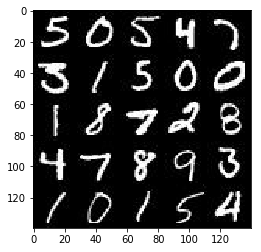

In [ ]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

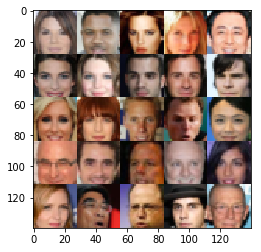

In [ ]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [ ]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), "input_real")
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), "input_z")
    learning_rate = tf.placeholder(tf.float32, name="lr")

    return real_inputs, z_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [ ]:
def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.5):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        x0 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same', activation=None)
        x0 = tf.maximum(alpha * x0, x0)
        
        x1 = tf.layers.conv2d(x0, 64, 5, strides=2, padding='same', activation=None)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        
        flat = tf.reshape(x3, (-1,  2 * 2 * 256))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [ ]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        g1 = tf.layers.dense(z, 4 * 4 * 512)
        g1 = tf.reshape(g1, (-1, 4, 4, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        
        g2 = tf.layers.conv2d_transpose(g1, 128, 4, strides=1, padding='valid', activation=None)
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        
        g3 = tf.layers.conv2d_transpose(g2, 64, 5, strides=2, padding='same', activation=None)
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)
        
        g4 = tf.layers.conv2d_transpose(g3, 32, 5, strides=2, padding='same', activation=None)
        g4 = tf.layers.batch_normalization(g4, training=is_train)
        g4 = tf.maximum(alpha * g4, g4)
        
        logits = tf.layers.conv2d_transpose(g4, out_channel_dim, 3, strides=1, padding='same', activation=None)
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [ ]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_output = generator(input_z, out_channel_dim)
    disc_output_real, disc_logits_real = discriminator(input_real)
    disc_output_fake, disc_logits_fake = discriminator(g_output, reuse=True)
    
    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_real,
            labels = tf.ones_like(disc_output_real) * (1 - smooth)
        )
    )
    disc_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.zeros_like(disc_output_fake)
        )
    )
    gen_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = disc_logits_fake,
            labels = tf.ones_like(disc_output_fake)
        )
    )
    
    disc_loss = disc_loss_real + disc_loss_fake
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [ ]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)

        return disc_train_opt, gen_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [ ]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [ ]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(disc_opt, feed_dict={
                        input_real: batch_images,
                        input_z: batch_z,
                        lr: learning_rate 
                    })
                
                _ = sess.run(gen_opt, feed_dict={
                        input_real: batch_images,
                        input_z: batch_z,
                        lr:learning_rate
                    })
                    
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                            "Generator Loss: {:.4f}".format(train_loss_g),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Generator Loss: 0.1287 Discriminator Loss: 2.6720...
Epoch 1/2... Generator Loss: 0.6380 Discriminator Loss: 1.7482...
Epoch 1/2... Generator Loss: 0.4543 Discriminator Loss: 1.7490...
Epoch 1/2... Generator Loss: 0.8193 Discriminator Loss: 1.5054...
Epoch 1/2... Generator Loss: 0.8780 Discriminator Loss: 1.4796...
Epoch 1/2... Generator Loss: 1.7211 Discriminator Loss: 1.5618...
Epoch 1/2... Generator Loss: 1.0765 Discriminator Loss: 1.5123...
Epoch 1/2... Generator Loss: 0.5312 Discriminator Loss: 1.5767...
Epoch 1/2... Generator Loss: 0.7379 Discriminator Loss: 1.4609...
Epoch 1/2... Generator Loss: 0.6190 Discriminator Loss: 1.6897...


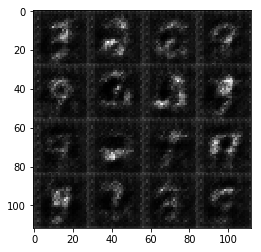

Epoch 1/2... Generator Loss: 0.8505 Discriminator Loss: 1.5726...
Epoch 1/2... Generator Loss: 0.8314 Discriminator Loss: 1.3281...
Epoch 1/2... Generator Loss: 1.3220 Discriminator Loss: 1.6550...
Epoch 1/2... Generator Loss: 0.7634 Discriminator Loss: 1.3889...
Epoch 1/2... Generator Loss: 0.8204 Discriminator Loss: 1.4755...
Epoch 1/2... Generator Loss: 1.1829 Discriminator Loss: 1.3691...
Epoch 1/2... Generator Loss: 0.8384 Discriminator Loss: 1.2280...
Epoch 1/2... Generator Loss: 1.0861 Discriminator Loss: 1.4123...
Epoch 1/2... Generator Loss: 1.4802 Discriminator Loss: 1.4502...
Epoch 1/2... Generator Loss: 1.0294 Discriminator Loss: 1.3282...


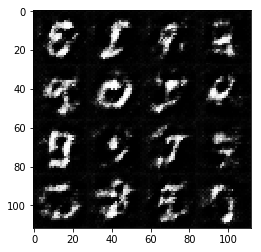

Epoch 1/2... Generator Loss: 1.2928 Discriminator Loss: 1.3729...
Epoch 1/2... Generator Loss: 1.0452 Discriminator Loss: 1.4955...
Epoch 1/2... Generator Loss: 1.2682 Discriminator Loss: 1.2531...
Epoch 1/2... Generator Loss: 0.6026 Discriminator Loss: 1.4183...
Epoch 1/2... Generator Loss: 1.3189 Discriminator Loss: 1.4840...
Epoch 1/2... Generator Loss: 0.8424 Discriminator Loss: 1.3444...
Epoch 1/2... Generator Loss: 1.2668 Discriminator Loss: 1.4715...
Epoch 1/2... Generator Loss: 1.0888 Discriminator Loss: 1.4366...
Epoch 1/2... Generator Loss: 1.0742 Discriminator Loss: 1.4551...
Epoch 1/2... Generator Loss: 1.0849 Discriminator Loss: 1.3959...


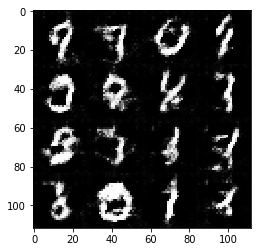

Epoch 1/2... Generator Loss: 1.0621 Discriminator Loss: 1.5471...
Epoch 1/2... Generator Loss: 0.7394 Discriminator Loss: 1.4303...
Epoch 1/2... Generator Loss: 0.8075 Discriminator Loss: 1.3876...
Epoch 1/2... Generator Loss: 0.7918 Discriminator Loss: 1.3895...
Epoch 1/2... Generator Loss: 1.0345 Discriminator Loss: 1.3290...
Epoch 1/2... Generator Loss: 1.4633 Discriminator Loss: 1.5711...
Epoch 1/2... Generator Loss: 1.1193 Discriminator Loss: 1.3062...
Epoch 1/2... Generator Loss: 0.9091 Discriminator Loss: 1.3646...
Epoch 1/2... Generator Loss: 0.5851 Discriminator Loss: 1.5589...
Epoch 1/2... Generator Loss: 0.7845 Discriminator Loss: 1.4047...


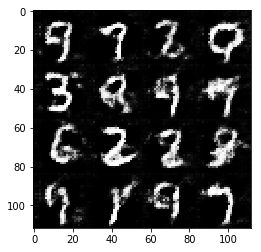

Epoch 1/2... Generator Loss: 0.9511 Discriminator Loss: 1.3617...
Epoch 1/2... Generator Loss: 1.0822 Discriminator Loss: 1.4940...
Epoch 1/2... Generator Loss: 1.0971 Discriminator Loss: 1.3309...
Epoch 1/2... Generator Loss: 0.9762 Discriminator Loss: 1.3441...
Epoch 1/2... Generator Loss: 0.8727 Discriminator Loss: 1.3400...
Epoch 1/2... Generator Loss: 0.8502 Discriminator Loss: 1.3714...
Epoch 1/2... Generator Loss: 0.9120 Discriminator Loss: 1.2424...
Epoch 1/2... Generator Loss: 1.0551 Discriminator Loss: 1.3549...
Epoch 1/2... Generator Loss: 0.6274 Discriminator Loss: 1.5029...
Epoch 1/2... Generator Loss: 0.8233 Discriminator Loss: 1.3346...


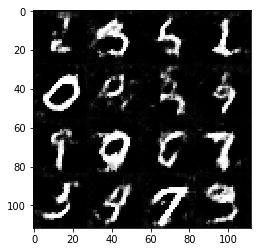

Epoch 1/2... Generator Loss: 1.3808 Discriminator Loss: 1.4004...
Epoch 1/2... Generator Loss: 0.7870 Discriminator Loss: 1.2870...
Epoch 1/2... Generator Loss: 0.4629 Discriminator Loss: 1.5387...
Epoch 1/2... Generator Loss: 0.8016 Discriminator Loss: 1.4153...
Epoch 1/2... Generator Loss: 0.9703 Discriminator Loss: 1.4087...
Epoch 1/2... Generator Loss: 0.6458 Discriminator Loss: 1.3895...
Epoch 1/2... Generator Loss: 1.0503 Discriminator Loss: 1.4004...
Epoch 1/2... Generator Loss: 1.3439 Discriminator Loss: 1.3218...
Epoch 1/2... Generator Loss: 0.8566 Discriminator Loss: 1.3529...
Epoch 1/2... Generator Loss: 0.8713 Discriminator Loss: 1.3490...


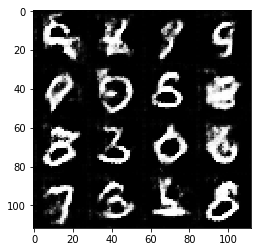

Epoch 1/2... Generator Loss: 0.7930 Discriminator Loss: 1.4096...
Epoch 1/2... Generator Loss: 0.7904 Discriminator Loss: 1.3697...
Epoch 1/2... Generator Loss: 0.7836 Discriminator Loss: 1.3930...
Epoch 1/2... Generator Loss: 1.0491 Discriminator Loss: 1.4469...
Epoch 1/2... Generator Loss: 0.8265 Discriminator Loss: 1.4202...
Epoch 1/2... Generator Loss: 0.9243 Discriminator Loss: 1.3718...
Epoch 1/2... Generator Loss: 0.8934 Discriminator Loss: 1.4165...
Epoch 1/2... Generator Loss: 0.5859 Discriminator Loss: 1.3555...
Epoch 1/2... Generator Loss: 0.6348 Discriminator Loss: 1.4478...
Epoch 1/2... Generator Loss: 0.9934 Discriminator Loss: 1.3297...


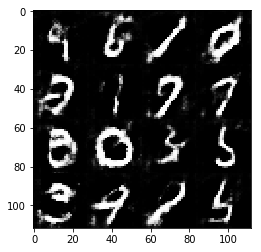

Epoch 1/2... Generator Loss: 0.9107 Discriminator Loss: 1.4067...
Epoch 1/2... Generator Loss: 0.9852 Discriminator Loss: 1.3274...
Epoch 1/2... Generator Loss: 0.7623 Discriminator Loss: 1.3705...
Epoch 1/2... Generator Loss: 0.8965 Discriminator Loss: 1.4216...
Epoch 1/2... Generator Loss: 1.1162 Discriminator Loss: 1.3479...
Epoch 1/2... Generator Loss: 0.8952 Discriminator Loss: 1.3120...
Epoch 1/2... Generator Loss: 0.7264 Discriminator Loss: 1.3512...
Epoch 1/2... Generator Loss: 0.9274 Discriminator Loss: 1.3982...
Epoch 1/2... Generator Loss: 1.0868 Discriminator Loss: 1.3933...
Epoch 1/2... Generator Loss: 0.7786 Discriminator Loss: 1.3638...


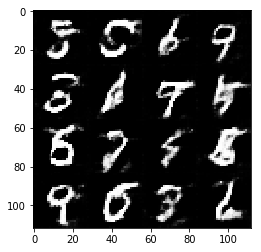

Epoch 1/2... Generator Loss: 0.9593 Discriminator Loss: 1.3852...
Epoch 1/2... Generator Loss: 0.8153 Discriminator Loss: 1.3358...
Epoch 1/2... Generator Loss: 1.1028 Discriminator Loss: 1.2143...
Epoch 1/2... Generator Loss: 0.7550 Discriminator Loss: 1.4040...
Epoch 1/2... Generator Loss: 0.9164 Discriminator Loss: 1.2776...
Epoch 1/2... Generator Loss: 0.6768 Discriminator Loss: 1.3978...
Epoch 1/2... Generator Loss: 0.6975 Discriminator Loss: 1.3547...
Epoch 1/2... Generator Loss: 0.7179 Discriminator Loss: 1.4277...
Epoch 1/2... Generator Loss: 0.7147 Discriminator Loss: 1.2862...
Epoch 1/2... Generator Loss: 0.7474 Discriminator Loss: 1.2607...


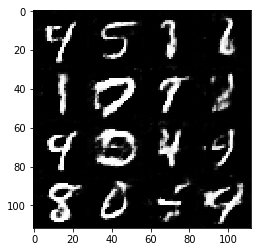

Epoch 1/2... Generator Loss: 0.7196 Discriminator Loss: 1.3974...
Epoch 1/2... Generator Loss: 1.1545 Discriminator Loss: 1.3016...
Epoch 1/2... Generator Loss: 1.0255 Discriminator Loss: 1.4217...
Epoch 2/2... Generator Loss: 0.8196 Discriminator Loss: 1.3866...
Epoch 2/2... Generator Loss: 0.8185 Discriminator Loss: 1.3981...
Epoch 2/2... Generator Loss: 0.6991 Discriminator Loss: 1.3953...
Epoch 2/2... Generator Loss: 0.6883 Discriminator Loss: 1.3476...
Epoch 2/2... Generator Loss: 1.0686 Discriminator Loss: 1.3366...
Epoch 2/2... Generator Loss: 1.0798 Discriminator Loss: 1.4443...
Epoch 2/2... Generator Loss: 0.8789 Discriminator Loss: 1.3938...


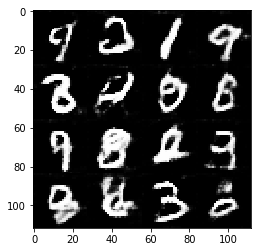

Epoch 2/2... Generator Loss: 0.7858 Discriminator Loss: 1.3319...
Epoch 2/2... Generator Loss: 0.8307 Discriminator Loss: 1.3744...
Epoch 2/2... Generator Loss: 0.8959 Discriminator Loss: 1.3075...
Epoch 2/2... Generator Loss: 0.9496 Discriminator Loss: 1.3628...
Epoch 2/2... Generator Loss: 1.1408 Discriminator Loss: 1.2873...
Epoch 2/2... Generator Loss: 0.8481 Discriminator Loss: 1.3137...
Epoch 2/2... Generator Loss: 0.8546 Discriminator Loss: 1.2392...
Epoch 2/2... Generator Loss: 1.0088 Discriminator Loss: 1.3747...
Epoch 2/2... Generator Loss: 0.6302 Discriminator Loss: 1.3762...
Epoch 2/2... Generator Loss: 0.6999 Discriminator Loss: 1.3851...


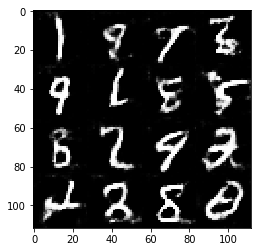

Epoch 2/2... Generator Loss: 1.2732 Discriminator Loss: 1.4534...
Epoch 2/2... Generator Loss: 0.7694 Discriminator Loss: 1.2310...
Epoch 2/2... Generator Loss: 0.6895 Discriminator Loss: 1.3694...
Epoch 2/2... Generator Loss: 0.7650 Discriminator Loss: 1.3189...
Epoch 2/2... Generator Loss: 0.9881 Discriminator Loss: 1.2297...
Epoch 2/2... Generator Loss: 1.0528 Discriminator Loss: 1.3012...
Epoch 2/2... Generator Loss: 0.7209 Discriminator Loss: 1.2652...
Epoch 2/2... Generator Loss: 0.7223 Discriminator Loss: 1.3293...
Epoch 2/2... Generator Loss: 0.8859 Discriminator Loss: 1.1902...
Epoch 2/2... Generator Loss: 0.9426 Discriminator Loss: 1.2360...


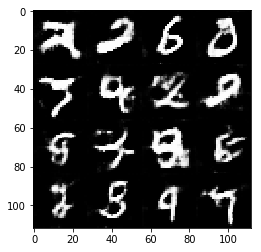

Epoch 2/2... Generator Loss: 1.0744 Discriminator Loss: 1.3418...
Epoch 2/2... Generator Loss: 0.9597 Discriminator Loss: 1.2029...
Epoch 2/2... Generator Loss: 0.7932 Discriminator Loss: 1.4068...
Epoch 2/2... Generator Loss: 0.8312 Discriminator Loss: 1.5899...
Epoch 2/2... Generator Loss: 0.8886 Discriminator Loss: 1.3751...
Epoch 2/2... Generator Loss: 0.6926 Discriminator Loss: 1.2979...
Epoch 2/2... Generator Loss: 0.7461 Discriminator Loss: 1.3100...
Epoch 2/2... Generator Loss: 0.7761 Discriminator Loss: 1.2359...
Epoch 2/2... Generator Loss: 0.5991 Discriminator Loss: 1.4743...
Epoch 2/2... Generator Loss: 1.0204 Discriminator Loss: 1.2881...


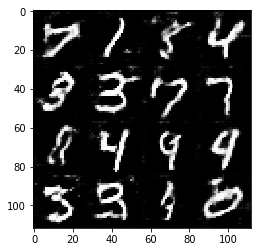

Epoch 2/2... Generator Loss: 0.6652 Discriminator Loss: 1.3163...
Epoch 2/2... Generator Loss: 0.7959 Discriminator Loss: 1.2680...
Epoch 2/2... Generator Loss: 0.5036 Discriminator Loss: 1.3738...
Epoch 2/2... Generator Loss: 0.7877 Discriminator Loss: 1.2763...
Epoch 2/2... Generator Loss: 0.7706 Discriminator Loss: 1.2150...
Epoch 2/2... Generator Loss: 0.7434 Discriminator Loss: 1.1876...
Epoch 2/2... Generator Loss: 0.7435 Discriminator Loss: 1.4204...
Epoch 2/2... Generator Loss: 0.7300 Discriminator Loss: 1.3093...
Epoch 2/2... Generator Loss: 1.2547 Discriminator Loss: 1.2601...
Epoch 2/2... Generator Loss: 0.7460 Discriminator Loss: 1.3303...


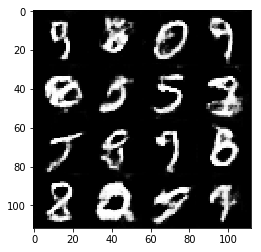

Epoch 2/2... Generator Loss: 0.7078 Discriminator Loss: 1.2955...
Epoch 2/2... Generator Loss: 0.5888 Discriminator Loss: 1.5384...
Epoch 2/2... Generator Loss: 0.8127 Discriminator Loss: 1.3299...
Epoch 2/2... Generator Loss: 0.7256 Discriminator Loss: 1.3059...
Epoch 2/2... Generator Loss: 1.0267 Discriminator Loss: 1.2712...
Epoch 2/2... Generator Loss: 1.1824 Discriminator Loss: 1.2684...
Epoch 2/2... Generator Loss: 1.1314 Discriminator Loss: 1.2209...
Epoch 2/2... Generator Loss: 0.7258 Discriminator Loss: 1.3030...
Epoch 2/2... Generator Loss: 0.7617 Discriminator Loss: 1.4006...
Epoch 2/2... Generator Loss: 0.4996 Discriminator Loss: 1.4940...


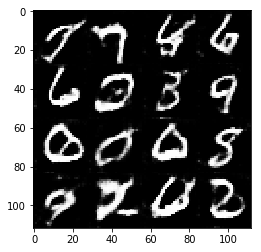

Epoch 2/2... Generator Loss: 0.6316 Discriminator Loss: 1.3388...
Epoch 2/2... Generator Loss: 0.9112 Discriminator Loss: 1.3081...
Epoch 2/2... Generator Loss: 0.7940 Discriminator Loss: 1.2954...
Epoch 2/2... Generator Loss: 0.6461 Discriminator Loss: 1.3516...
Epoch 2/2... Generator Loss: 0.5386 Discriminator Loss: 1.3148...
Epoch 2/2... Generator Loss: 0.8379 Discriminator Loss: 1.3554...
Epoch 2/2... Generator Loss: 0.8333 Discriminator Loss: 1.2222...
Epoch 2/2... Generator Loss: 0.8683 Discriminator Loss: 1.2461...
Epoch 2/2... Generator Loss: 1.5559 Discriminator Loss: 1.3141...
Epoch 2/2... Generator Loss: 0.9740 Discriminator Loss: 1.3582...


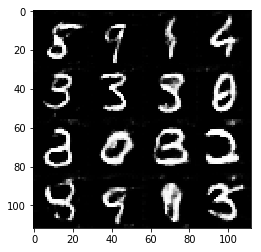

Epoch 2/2... Generator Loss: 0.9467 Discriminator Loss: 1.3223...
Epoch 2/2... Generator Loss: 0.8642 Discriminator Loss: 1.1176...
Epoch 2/2... Generator Loss: 0.3955 Discriminator Loss: 1.6650...
Epoch 2/2... Generator Loss: 0.6823 Discriminator Loss: 1.3503...
Epoch 2/2... Generator Loss: 0.6634 Discriminator Loss: 1.3730...
Epoch 2/2... Generator Loss: 1.8660 Discriminator Loss: 1.5480...
Epoch 2/2... Generator Loss: 0.4629 Discriminator Loss: 1.4860...
Epoch 2/2... Generator Loss: 1.3564 Discriminator Loss: 1.1795...
Epoch 2/2... Generator Loss: 0.5420 Discriminator Loss: 1.3755...
Epoch 2/2... Generator Loss: 0.8926 Discriminator Loss: 1.0856...


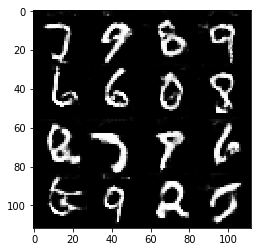

Epoch 2/2... Generator Loss: 0.5512 Discriminator Loss: 1.4036...
Epoch 2/2... Generator Loss: 0.5401 Discriminator Loss: 1.3661...
Epoch 2/2... Generator Loss: 0.5715 Discriminator Loss: 1.3757...
Epoch 2/2... Generator Loss: 1.1137 Discriminator Loss: 1.2594...
Epoch 2/2... Generator Loss: 1.1879 Discriminator Loss: 1.1524...
Epoch 2/2... Generator Loss: 0.5652 Discriminator Loss: 1.3732...
Epoch 2/2... Generator Loss: 1.6604 Discriminator Loss: 1.1779...
Epoch 2/2... Generator Loss: 0.6330 Discriminator Loss: 1.3397...
Epoch 2/2... Generator Loss: 1.3789 Discriminator Loss: 1.3419...
Epoch 2/2... Generator Loss: 1.5632 Discriminator Loss: 1.5191...


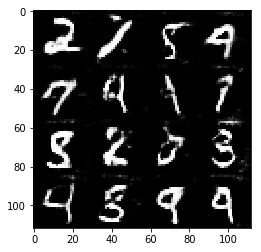

Epoch 2/2... Generator Loss: 0.6004 Discriminator Loss: 1.3176...
Epoch 2/2... Generator Loss: 0.9125 Discriminator Loss: 1.2535...
Epoch 2/2... Generator Loss: 0.8374 Discriminator Loss: 1.0978...
Epoch 2/2... Generator Loss: 0.6296 Discriminator Loss: 1.3925...
Epoch 2/2... Generator Loss: 0.7314 Discriminator Loss: 1.2821...
Epoch 2/2... Generator Loss: 0.7730 Discriminator Loss: 1.2969...
Epoch 2/2... Generator Loss: 0.9544 Discriminator Loss: 1.3177...


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Generator Loss: 0.1822 Discriminator Loss: 3.1429...
Epoch 1/1... Generator Loss: 0.2707 Discriminator Loss: 2.7307...
Epoch 1/1... Generator Loss: 1.8793 Discriminator Loss: 0.8426...
Epoch 1/1... Generator Loss: 1.8926 Discriminator Loss: 1.2964...
Epoch 1/1... Generator Loss: 0.8719 Discriminator Loss: 1.1812...
Epoch 1/1... Generator Loss: 0.6596 Discriminator Loss: 1.3580...
Epoch 1/1... Generator Loss: 0.7982 Discriminator Loss: 1.3979...
Epoch 1/1... Generator Loss: 0.2784 Discriminator Loss: 2.1696...
Epoch 1/1... Generator Loss: 0.8502 Discriminator Loss: 1.2354...
Epoch 1/1... Generator Loss: 1.2025 Discriminator Loss: 1.1624...


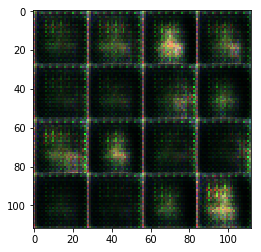

Epoch 1/1... Generator Loss: 0.5403 Discriminator Loss: 1.7193...
Epoch 1/1... Generator Loss: 0.3025 Discriminator Loss: 2.1451...
Epoch 1/1... Generator Loss: 1.0578 Discriminator Loss: 1.1481...
Epoch 1/1... Generator Loss: 0.7007 Discriminator Loss: 1.4339...
Epoch 1/1... Generator Loss: 3.1777 Discriminator Loss: 1.6657...
Epoch 1/1... Generator Loss: 3.3939 Discriminator Loss: 1.5839...
Epoch 1/1... Generator Loss: 1.4008 Discriminator Loss: 0.7890...
Epoch 1/1... Generator Loss: 0.5186 Discriminator Loss: 1.6691...
Epoch 1/1... Generator Loss: 0.7068 Discriminator Loss: 1.5160...
Epoch 1/1... Generator Loss: 0.9321 Discriminator Loss: 0.9775...


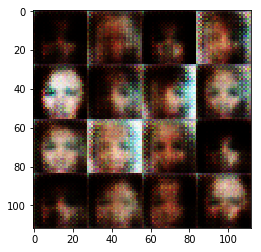

Epoch 1/1... Generator Loss: 0.5452 Discriminator Loss: 1.6236...
Epoch 1/1... Generator Loss: 0.8063 Discriminator Loss: 1.4095...
Epoch 1/1... Generator Loss: 1.2926 Discriminator Loss: 1.2941...
Epoch 1/1... Generator Loss: 1.5205 Discriminator Loss: 1.0057...
Epoch 1/1... Generator Loss: 1.5752 Discriminator Loss: 1.4153...
Epoch 1/1... Generator Loss: 0.3475 Discriminator Loss: 1.9783...
Epoch 1/1... Generator Loss: 0.7958 Discriminator Loss: 1.5612...
Epoch 1/1... Generator Loss: 1.0324 Discriminator Loss: 1.0561...
Epoch 1/1... Generator Loss: 0.8812 Discriminator Loss: 1.3990...
Epoch 1/1... Generator Loss: 0.9120 Discriminator Loss: 1.3873...


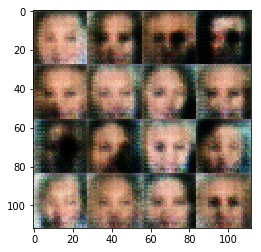

Epoch 1/1... Generator Loss: 0.5974 Discriminator Loss: 1.4286...
Epoch 1/1... Generator Loss: 1.6946 Discriminator Loss: 1.1059...
Epoch 1/1... Generator Loss: 1.0732 Discriminator Loss: 1.2089...
Epoch 1/1... Generator Loss: 0.8537 Discriminator Loss: 1.3947...
Epoch 1/1... Generator Loss: 1.2795 Discriminator Loss: 0.9926...
Epoch 1/1... Generator Loss: 1.0174 Discriminator Loss: 1.0826...
Epoch 1/1... Generator Loss: 1.0141 Discriminator Loss: 1.3226...
Epoch 1/1... Generator Loss: 0.5255 Discriminator Loss: 1.5793...
Epoch 1/1... Generator Loss: 1.1462 Discriminator Loss: 1.2219...
Epoch 1/1... Generator Loss: 1.2808 Discriminator Loss: 1.3753...


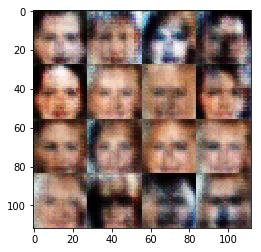

Epoch 1/1... Generator Loss: 0.3088 Discriminator Loss: 2.0151...
Epoch 1/1... Generator Loss: 0.8686 Discriminator Loss: 1.3552...
Epoch 1/1... Generator Loss: 0.9183 Discriminator Loss: 1.3540...
Epoch 1/1... Generator Loss: 0.8738 Discriminator Loss: 1.4130...
Epoch 1/1... Generator Loss: 0.7539 Discriminator Loss: 1.6618...
Epoch 1/1... Generator Loss: 0.6191 Discriminator Loss: 1.4719...
Epoch 1/1... Generator Loss: 1.0795 Discriminator Loss: 1.2561...
Epoch 1/1... Generator Loss: 0.8018 Discriminator Loss: 1.5118...
Epoch 1/1... Generator Loss: 0.9465 Discriminator Loss: 1.3118...
Epoch 1/1... Generator Loss: 0.6447 Discriminator Loss: 1.4199...


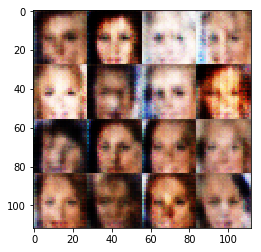

Epoch 1/1... Generator Loss: 1.1962 Discriminator Loss: 1.3001...
Epoch 1/1... Generator Loss: 0.7162 Discriminator Loss: 1.2746...
Epoch 1/1... Generator Loss: 0.5353 Discriminator Loss: 1.4352...
Epoch 1/1... Generator Loss: 0.7695 Discriminator Loss: 1.4268...
Epoch 1/1... Generator Loss: 0.6417 Discriminator Loss: 1.4619...
Epoch 1/1... Generator Loss: 0.7793 Discriminator Loss: 1.2683...
Epoch 1/1... Generator Loss: 0.5382 Discriminator Loss: 1.3152...
Epoch 1/1... Generator Loss: 1.6758 Discriminator Loss: 0.9994...
Epoch 1/1... Generator Loss: 0.8986 Discriminator Loss: 1.3437...
Epoch 1/1... Generator Loss: 0.8760 Discriminator Loss: 1.2467...


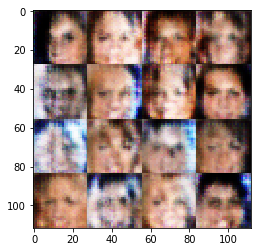

Epoch 1/1... Generator Loss: 0.5228 Discriminator Loss: 1.4332...
Epoch 1/1... Generator Loss: 0.8364 Discriminator Loss: 1.3473...
Epoch 1/1... Generator Loss: 0.9098 Discriminator Loss: 1.3046...
Epoch 1/1... Generator Loss: 0.3420 Discriminator Loss: 1.7755...
Epoch 1/1... Generator Loss: 0.8262 Discriminator Loss: 1.3641...
Epoch 1/1... Generator Loss: 0.9605 Discriminator Loss: 1.2864...
Epoch 1/1... Generator Loss: 0.6930 Discriminator Loss: 1.2247...
Epoch 1/1... Generator Loss: 1.2367 Discriminator Loss: 1.0511...
Epoch 1/1... Generator Loss: 3.0022 Discriminator Loss: 2.5082...
Epoch 1/1... Generator Loss: 0.9640 Discriminator Loss: 1.2294...


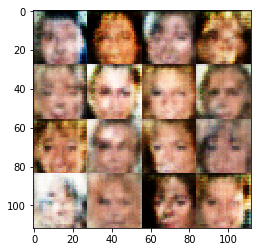

Epoch 1/1... Generator Loss: 0.7361 Discriminator Loss: 1.6515...
Epoch 1/1... Generator Loss: 0.9151 Discriminator Loss: 1.3130...
Epoch 1/1... Generator Loss: 0.6278 Discriminator Loss: 1.2948...
Epoch 1/1... Generator Loss: 1.0695 Discriminator Loss: 0.9880...
Epoch 1/1... Generator Loss: 1.0827 Discriminator Loss: 1.1781...
Epoch 1/1... Generator Loss: 1.0283 Discriminator Loss: 1.2490...
Epoch 1/1... Generator Loss: 0.5375 Discriminator Loss: 1.3206...
Epoch 1/1... Generator Loss: 0.7523 Discriminator Loss: 1.3675...
Epoch 1/1... Generator Loss: 0.8161 Discriminator Loss: 1.2789...
Epoch 1/1... Generator Loss: 0.8107 Discriminator Loss: 1.3782...


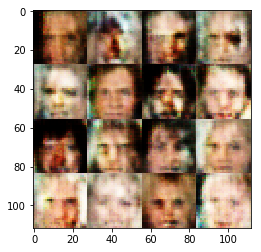

Epoch 1/1... Generator Loss: 0.6561 Discriminator Loss: 1.2547...
Epoch 1/1... Generator Loss: 1.0572 Discriminator Loss: 1.1290...
Epoch 1/1... Generator Loss: 0.7145 Discriminator Loss: 1.3308...
Epoch 1/1... Generator Loss: 0.7137 Discriminator Loss: 1.3273...
Epoch 1/1... Generator Loss: 0.9563 Discriminator Loss: 1.3084...
Epoch 1/1... Generator Loss: 1.3864 Discriminator Loss: 1.3042...
Epoch 1/1... Generator Loss: 0.8833 Discriminator Loss: 1.1446...
Epoch 1/1... Generator Loss: 1.8682 Discriminator Loss: 1.5339...
Epoch 1/1... Generator Loss: 0.3977 Discriminator Loss: 1.7221...
Epoch 1/1... Generator Loss: 0.7065 Discriminator Loss: 1.3653...


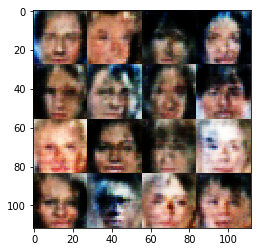

Epoch 1/1... Generator Loss: 0.7721 Discriminator Loss: 1.2946...
Epoch 1/1... Generator Loss: 0.8149 Discriminator Loss: 1.3984...
Epoch 1/1... Generator Loss: 0.9876 Discriminator Loss: 1.2107...
Epoch 1/1... Generator Loss: 1.5042 Discriminator Loss: 2.0863...
Epoch 1/1... Generator Loss: 0.9688 Discriminator Loss: 1.2734...
Epoch 1/1... Generator Loss: 1.1592 Discriminator Loss: 1.2553...
Epoch 1/1... Generator Loss: 0.6880 Discriminator Loss: 1.3337...
Epoch 1/1... Generator Loss: 1.3184 Discriminator Loss: 1.3898...
Epoch 1/1... Generator Loss: 0.7788 Discriminator Loss: 1.1813...
Epoch 1/1... Generator Loss: 1.3137 Discriminator Loss: 1.4234...


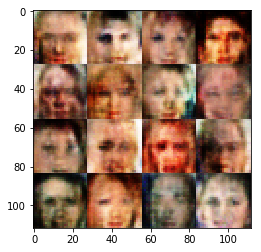

Epoch 1/1... Generator Loss: 1.3700 Discriminator Loss: 1.2805...
Epoch 1/1... Generator Loss: 0.9324 Discriminator Loss: 1.2686...
Epoch 1/1... Generator Loss: 0.6231 Discriminator Loss: 1.3685...
Epoch 1/1... Generator Loss: 0.5677 Discriminator Loss: 1.4490...
Epoch 1/1... Generator Loss: 1.0263 Discriminator Loss: 1.2237...
Epoch 1/1... Generator Loss: 1.3718 Discriminator Loss: 1.2890...
Epoch 1/1... Generator Loss: 0.5929 Discriminator Loss: 1.2972...
Epoch 1/1... Generator Loss: 0.8095 Discriminator Loss: 1.2620...
Epoch 1/1... Generator Loss: 0.6795 Discriminator Loss: 1.2811...
Epoch 1/1... Generator Loss: 0.7469 Discriminator Loss: 1.2418...


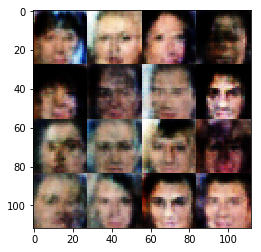

Epoch 1/1... Generator Loss: 1.2116 Discriminator Loss: 1.1950...
Epoch 1/1... Generator Loss: 0.5519 Discriminator Loss: 1.4034...
Epoch 1/1... Generator Loss: 0.9039 Discriminator Loss: 1.3410...
Epoch 1/1... Generator Loss: 0.9587 Discriminator Loss: 1.3416...
Epoch 1/1... Generator Loss: 0.6796 Discriminator Loss: 1.2606...
Epoch 1/1... Generator Loss: 1.0003 Discriminator Loss: 1.0225...
Epoch 1/1... Generator Loss: 0.8555 Discriminator Loss: 1.1423...
Epoch 1/1... Generator Loss: 0.9002 Discriminator Loss: 1.2962...
Epoch 1/1... Generator Loss: 0.7926 Discriminator Loss: 1.2879...
Epoch 1/1... Generator Loss: 0.6911 Discriminator Loss: 1.2105...


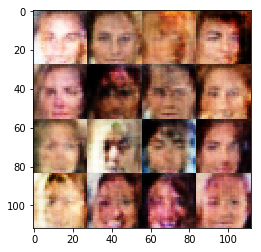

Epoch 1/1... Generator Loss: 0.8335 Discriminator Loss: 1.3345...
Epoch 1/1... Generator Loss: 1.3215 Discriminator Loss: 1.3033...
Epoch 1/1... Generator Loss: 1.1264 Discriminator Loss: 1.4632...
Epoch 1/1... Generator Loss: 1.3270 Discriminator Loss: 1.1693...
Epoch 1/1... Generator Loss: 0.6595 Discriminator Loss: 1.3194...
Epoch 1/1... Generator Loss: 0.7443 Discriminator Loss: 1.3205...
Epoch 1/1... Generator Loss: 1.2987 Discriminator Loss: 1.0793...
Epoch 1/1... Generator Loss: 1.2965 Discriminator Loss: 1.2188...
Epoch 1/1... Generator Loss: 0.9159 Discriminator Loss: 1.2150...
Epoch 1/1... Generator Loss: 0.8973 Discriminator Loss: 1.3880...


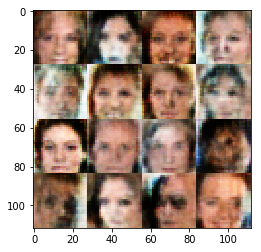

Epoch 1/1... Generator Loss: 1.7709 Discriminator Loss: 1.5945...
Epoch 1/1... Generator Loss: 0.5801 Discriminator Loss: 1.3314...
Epoch 1/1... Generator Loss: 0.6640 Discriminator Loss: 1.3218...
Epoch 1/1... Generator Loss: 0.6765 Discriminator Loss: 1.3105...
Epoch 1/1... Generator Loss: 0.8001 Discriminator Loss: 1.3820...
Epoch 1/1... Generator Loss: 1.7563 Discriminator Loss: 1.1562...
Epoch 1/1... Generator Loss: 0.5467 Discriminator Loss: 1.2250...
Epoch 1/1... Generator Loss: 1.0213 Discriminator Loss: 1.2267...
Epoch 1/1... Generator Loss: 1.3838 Discriminator Loss: 1.3618...
Epoch 1/1... Generator Loss: 2.0630 Discriminator Loss: 1.4628...


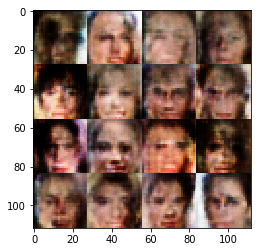

Epoch 1/1... Generator Loss: 0.8216 Discriminator Loss: 1.4706...
Epoch 1/1... Generator Loss: 0.7772 Discriminator Loss: 1.4212...
Epoch 1/1... Generator Loss: 0.7474 Discriminator Loss: 1.4872...
Epoch 1/1... Generator Loss: 1.0117 Discriminator Loss: 1.0269...
Epoch 1/1... Generator Loss: 0.9250 Discriminator Loss: 1.1606...
Epoch 1/1... Generator Loss: 1.0263 Discriminator Loss: 1.4499...
Epoch 1/1... Generator Loss: 0.8589 Discriminator Loss: 1.1903...
Epoch 1/1... Generator Loss: 0.5839 Discriminator Loss: 1.2757...
Epoch 1/1... Generator Loss: 0.9377 Discriminator Loss: 1.1372...
Epoch 1/1... Generator Loss: 1.5950 Discriminator Loss: 1.2046...


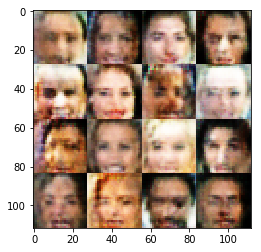

Epoch 1/1... Generator Loss: 0.6835 Discriminator Loss: 1.5339...
Epoch 1/1... Generator Loss: 1.0682 Discriminator Loss: 0.9777...
Epoch 1/1... Generator Loss: 1.3017 Discriminator Loss: 1.1706...
Epoch 1/1... Generator Loss: 0.7645 Discriminator Loss: 1.1542...
Epoch 1/1... Generator Loss: 0.7151 Discriminator Loss: 1.3870...
Epoch 1/1... Generator Loss: 0.9448 Discriminator Loss: 1.1567...
Epoch 1/1... Generator Loss: 0.8988 Discriminator Loss: 1.1559...
Epoch 1/1... Generator Loss: 0.8600 Discriminator Loss: 1.2929...
Epoch 1/1... Generator Loss: 1.1889 Discriminator Loss: 1.4383...
Epoch 1/1... Generator Loss: 0.6642 Discriminator Loss: 1.3544...


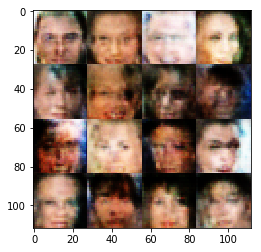

Epoch 1/1... Generator Loss: 0.6292 Discriminator Loss: 1.1843...
Epoch 1/1... Generator Loss: 0.6578 Discriminator Loss: 1.3728...
Epoch 1/1... Generator Loss: 0.4872 Discriminator Loss: 1.5045...
Epoch 1/1... Generator Loss: 1.4190 Discriminator Loss: 1.1533...
Epoch 1/1... Generator Loss: 0.6518 Discriminator Loss: 1.2168...
Epoch 1/1... Generator Loss: 1.5219 Discriminator Loss: 0.8512...
Epoch 1/1... Generator Loss: 1.3707 Discriminator Loss: 0.8482...
Epoch 1/1... Generator Loss: 0.5476 Discriminator Loss: 1.2092...
Epoch 1/1... Generator Loss: 0.9061 Discriminator Loss: 1.2387...
Epoch 1/1... Generator Loss: 0.7320 Discriminator Loss: 1.3911...


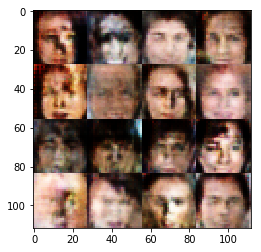

Epoch 1/1... Generator Loss: 0.7365 Discriminator Loss: 1.2968...
Epoch 1/1... Generator Loss: 1.2753 Discriminator Loss: 1.1923...
Epoch 1/1... Generator Loss: 0.8547 Discriminator Loss: 1.2061...
Epoch 1/1... Generator Loss: 1.1295 Discriminator Loss: 1.2351...
Epoch 1/1... Generator Loss: 0.5810 Discriminator Loss: 1.3443...
Epoch 1/1... Generator Loss: 0.7955 Discriminator Loss: 1.2559...
Epoch 1/1... Generator Loss: 0.7215 Discriminator Loss: 1.4474...
Epoch 1/1... Generator Loss: 0.8380 Discriminator Loss: 1.2825...
Epoch 1/1... Generator Loss: 1.3502 Discriminator Loss: 1.1289...
Epoch 1/1... Generator Loss: 0.9823 Discriminator Loss: 1.2036...


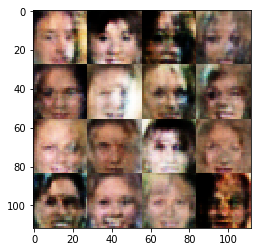

Epoch 1/1... Generator Loss: 1.3062 Discriminator Loss: 1.2181...
Epoch 1/1... Generator Loss: 1.8641 Discriminator Loss: 0.8792...
Epoch 1/1... Generator Loss: 0.7865 Discriminator Loss: 1.2182...
Epoch 1/1... Generator Loss: 0.7067 Discriminator Loss: 1.3320...
Epoch 1/1... Generator Loss: 1.0390 Discriminator Loss: 1.0300...
Epoch 1/1... Generator Loss: 1.0319 Discriminator Loss: 1.1377...
Epoch 1/1... Generator Loss: 0.8285 Discriminator Loss: 1.3127...
Epoch 1/1... Generator Loss: 1.2760 Discriminator Loss: 1.5709...
Epoch 1/1... Generator Loss: 0.7536 Discriminator Loss: 1.3281...
Epoch 1/1... Generator Loss: 1.1354 Discriminator Loss: 1.0541...


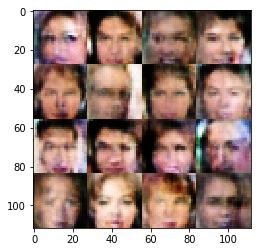

Epoch 1/1... Generator Loss: 0.7410 Discriminator Loss: 1.2504...
Epoch 1/1... Generator Loss: 0.7806 Discriminator Loss: 1.3266...
Epoch 1/1... Generator Loss: 0.6045 Discriminator Loss: 1.3127...
Epoch 1/1... Generator Loss: 1.4051 Discriminator Loss: 0.8457...
Epoch 1/1... Generator Loss: 0.6019 Discriminator Loss: 1.4285...
Epoch 1/1... Generator Loss: 0.8572 Discriminator Loss: 1.2747...
Epoch 1/1... Generator Loss: 0.7245 Discriminator Loss: 1.2442...
Epoch 1/1... Generator Loss: 0.9736 Discriminator Loss: 1.3459...
Epoch 1/1... Generator Loss: 0.7820 Discriminator Loss: 1.2157...
Epoch 1/1... Generator Loss: 0.6163 Discriminator Loss: 1.5058...


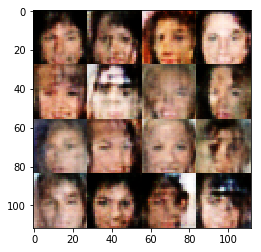

Epoch 1/1... Generator Loss: 0.6678 Discriminator Loss: 1.1749...
Epoch 1/1... Generator Loss: 0.8344 Discriminator Loss: 1.2771...
Epoch 1/1... Generator Loss: 0.5729 Discriminator Loss: 1.4376...
Epoch 1/1... Generator Loss: 1.7571 Discriminator Loss: 1.4719...
Epoch 1/1... Generator Loss: 0.7002 Discriminator Loss: 1.2347...
Epoch 1/1... Generator Loss: 1.1855 Discriminator Loss: 1.2763...
Epoch 1/1... Generator Loss: 0.7393 Discriminator Loss: 1.3810...
Epoch 1/1... Generator Loss: 0.9965 Discriminator Loss: 1.0264...
Epoch 1/1... Generator Loss: 1.3149 Discriminator Loss: 1.2557...
Epoch 1/1... Generator Loss: 0.6870 Discriminator Loss: 1.3558...


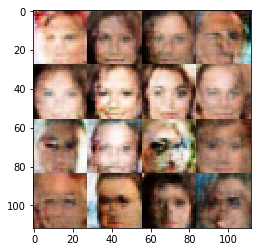

Epoch 1/1... Generator Loss: 0.5332 Discriminator Loss: 1.3366...
Epoch 1/1... Generator Loss: 0.6767 Discriminator Loss: 1.2862...
Epoch 1/1... Generator Loss: 0.6043 Discriminator Loss: 1.4029...
Epoch 1/1... Generator Loss: 1.0845 Discriminator Loss: 1.2472...
Epoch 1/1... Generator Loss: 0.8141 Discriminator Loss: 1.2465...
Epoch 1/1... Generator Loss: 0.6253 Discriminator Loss: 1.3623...
Epoch 1/1... Generator Loss: 0.7513 Discriminator Loss: 1.0658...
Epoch 1/1... Generator Loss: 0.8222 Discriminator Loss: 1.2116...
Epoch 1/1... Generator Loss: 0.7088 Discriminator Loss: 1.4286...
Epoch 1/1... Generator Loss: 1.2256 Discriminator Loss: 1.1908...


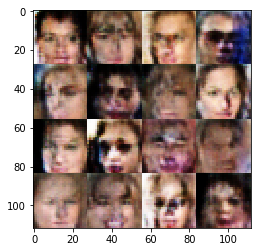

Epoch 1/1... Generator Loss: 0.8022 Discriminator Loss: 1.3265...
Epoch 1/1... Generator Loss: 0.5919 Discriminator Loss: 1.4116...
Epoch 1/1... Generator Loss: 0.3254 Discriminator Loss: 1.7739...
Epoch 1/1... Generator Loss: 1.3014 Discriminator Loss: 1.2507...
Epoch 1/1... Generator Loss: 1.7845 Discriminator Loss: 1.2301...
Epoch 1/1... Generator Loss: 1.0169 Discriminator Loss: 1.4069...
Epoch 1/1... Generator Loss: 1.3947 Discriminator Loss: 1.0700...
Epoch 1/1... Generator Loss: 1.0855 Discriminator Loss: 1.3339...
Epoch 1/1... Generator Loss: 1.0720 Discriminator Loss: 1.2382...
Epoch 1/1... Generator Loss: 0.5779 Discriminator Loss: 1.5211...


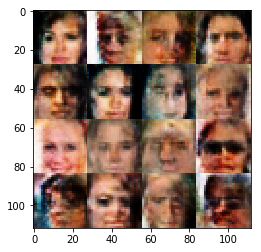

Epoch 1/1... Generator Loss: 0.6307 Discriminator Loss: 1.4255...
Epoch 1/1... Generator Loss: 0.9965 Discriminator Loss: 1.1070...
Epoch 1/1... Generator Loss: 0.7572 Discriminator Loss: 1.3533...
Epoch 1/1... Generator Loss: 0.4396 Discriminator Loss: 1.4175...
Epoch 1/1... Generator Loss: 0.8993 Discriminator Loss: 1.3051...
Epoch 1/1... Generator Loss: 1.1372 Discriminator Loss: 1.0602...
Epoch 1/1... Generator Loss: 0.7326 Discriminator Loss: 1.4142...
Epoch 1/1... Generator Loss: 0.7675 Discriminator Loss: 1.4404...
Epoch 1/1... Generator Loss: 0.6503 Discriminator Loss: 1.3678...
Epoch 1/1... Generator Loss: 0.6970 Discriminator Loss: 1.5170...


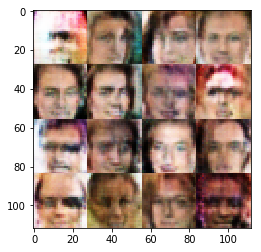

Epoch 1/1... Generator Loss: 0.7480 Discriminator Loss: 1.4154...
Epoch 1/1... Generator Loss: 0.7727 Discriminator Loss: 1.2223...
Epoch 1/1... Generator Loss: 0.9668 Discriminator Loss: 1.3788...
Epoch 1/1... Generator Loss: 0.7584 Discriminator Loss: 1.2731...
Epoch 1/1... Generator Loss: 0.8892 Discriminator Loss: 1.3011...
Epoch 1/1... Generator Loss: 0.4825 Discriminator Loss: 1.4895...
Epoch 1/1... Generator Loss: 1.0122 Discriminator Loss: 1.1263...
Epoch 1/1... Generator Loss: 0.9469 Discriminator Loss: 1.2530...
Epoch 1/1... Generator Loss: 0.7095 Discriminator Loss: 1.2400...
Epoch 1/1... Generator Loss: 0.7779 Discriminator Loss: 1.3076...


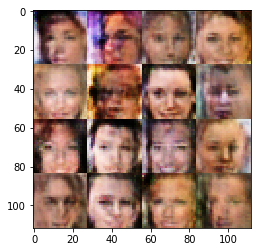

Epoch 1/1... Generator Loss: 0.7248 Discriminator Loss: 1.2463...
Epoch 1/1... Generator Loss: 1.1038 Discriminator Loss: 1.0205...
Epoch 1/1... Generator Loss: 1.3051 Discriminator Loss: 1.4998...
Epoch 1/1... Generator Loss: 0.6676 Discriminator Loss: 1.5187...
Epoch 1/1... Generator Loss: 0.7670 Discriminator Loss: 1.3212...
Epoch 1/1... Generator Loss: 0.6598 Discriminator Loss: 1.4303...
Epoch 1/1... Generator Loss: 0.6458 Discriminator Loss: 1.4235...
Epoch 1/1... Generator Loss: 0.5157 Discriminator Loss: 1.5045...
Epoch 1/1... Generator Loss: 0.6438 Discriminator Loss: 1.2997...
Epoch 1/1... Generator Loss: 0.8769 Discriminator Loss: 1.1445...


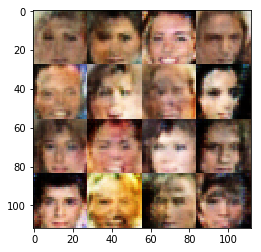

Epoch 1/1... Generator Loss: 0.6923 Discriminator Loss: 1.2267...
Epoch 1/1... Generator Loss: 0.5440 Discriminator Loss: 1.3255...
Epoch 1/1... Generator Loss: 0.8987 Discriminator Loss: 1.1775...
Epoch 1/1... Generator Loss: 0.5787 Discriminator Loss: 1.4551...
Epoch 1/1... Generator Loss: 1.0982 Discriminator Loss: 1.5607...
Epoch 1/1... Generator Loss: 1.1045 Discriminator Loss: 1.0206...
Epoch 1/1... Generator Loss: 0.5699 Discriminator Loss: 1.6110...
Epoch 1/1... Generator Loss: 1.0779 Discriminator Loss: 1.0861...
Epoch 1/1... Generator Loss: 1.0882 Discriminator Loss: 1.2377...
Epoch 1/1... Generator Loss: 0.7871 Discriminator Loss: 1.2615...


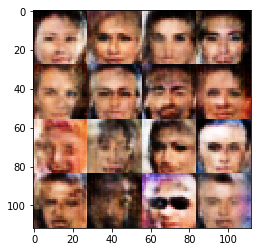

Epoch 1/1... Generator Loss: 1.6348 Discriminator Loss: 1.2904...
Epoch 1/1... Generator Loss: 0.7778 Discriminator Loss: 1.2650...
Epoch 1/1... Generator Loss: 0.7634 Discriminator Loss: 1.0768...
Epoch 1/1... Generator Loss: 0.9491 Discriminator Loss: 1.1086...
Epoch 1/1... Generator Loss: 0.7870 Discriminator Loss: 1.4225...
Epoch 1/1... Generator Loss: 0.8435 Discriminator Loss: 1.4185...
Epoch 1/1... Generator Loss: 0.3923 Discriminator Loss: 1.6898...
Epoch 1/1... Generator Loss: 0.8670 Discriminator Loss: 1.1526...
Epoch 1/1... Generator Loss: 0.6450 Discriminator Loss: 1.4300...
Epoch 1/1... Generator Loss: 0.8194 Discriminator Loss: 1.3344...


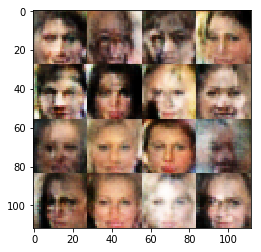

Epoch 1/1... Generator Loss: 0.6620 Discriminator Loss: 1.3189...
Epoch 1/1... Generator Loss: 1.3467 Discriminator Loss: 1.1650...
Epoch 1/1... Generator Loss: 0.8396 Discriminator Loss: 1.3751...
Epoch 1/1... Generator Loss: 0.8878 Discriminator Loss: 1.2726...
Epoch 1/1... Generator Loss: 1.1538 Discriminator Loss: 1.0688...
Epoch 1/1... Generator Loss: 0.9828 Discriminator Loss: 1.0833...
Epoch 1/1... Generator Loss: 0.9139 Discriminator Loss: 1.3228...
Epoch 1/1... Generator Loss: 1.6001 Discriminator Loss: 1.0240...
Epoch 1/1... Generator Loss: 1.0657 Discriminator Loss: 1.3187...
Epoch 1/1... Generator Loss: 1.3261 Discriminator Loss: 0.9037...


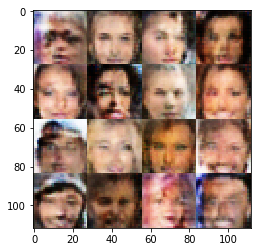

Epoch 1/1... Generator Loss: 0.7069 Discriminator Loss: 1.2285...
Epoch 1/1... Generator Loss: 0.6768 Discriminator Loss: 1.3623...
Epoch 1/1... Generator Loss: 1.4250 Discriminator Loss: 1.2735...
Epoch 1/1... Generator Loss: 1.1191 Discriminator Loss: 1.2326...
Epoch 1/1... Generator Loss: 1.0959 Discriminator Loss: 1.2039...
Epoch 1/1... Generator Loss: 0.6823 Discriminator Loss: 1.1868...
Epoch 1/1... Generator Loss: 0.4988 Discriminator Loss: 1.4303...
Epoch 1/1... Generator Loss: 0.8315 Discriminator Loss: 1.0707...
Epoch 1/1... Generator Loss: 1.1704 Discriminator Loss: 1.2747...
Epoch 1/1... Generator Loss: 0.8334 Discriminator Loss: 1.3111...


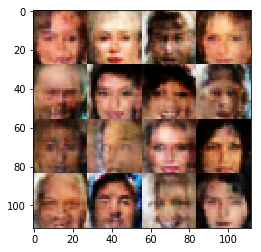

Epoch 1/1... Generator Loss: 0.8031 Discriminator Loss: 1.2033...
Epoch 1/1... Generator Loss: 1.0178 Discriminator Loss: 1.3855...
Epoch 1/1... Generator Loss: 1.1571 Discriminator Loss: 1.1969...
Epoch 1/1... Generator Loss: 0.5862 Discriminator Loss: 1.3504...
Epoch 1/1... Generator Loss: 0.7745 Discriminator Loss: 1.3429...
Epoch 1/1... Generator Loss: 0.8812 Discriminator Loss: 1.2034...
Epoch 1/1... Generator Loss: 1.2245 Discriminator Loss: 1.1988...
Epoch 1/1... Generator Loss: 0.9049 Discriminator Loss: 1.2180...
Epoch 1/1... Generator Loss: 0.5094 Discriminator Loss: 1.5128...
Epoch 1/1... Generator Loss: 0.6019 Discriminator Loss: 1.2793...


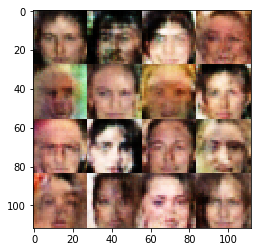

Epoch 1/1... Generator Loss: 0.8687 Discriminator Loss: 1.2820...
Epoch 1/1... Generator Loss: 2.0394 Discriminator Loss: 2.0997...
Epoch 1/1... Generator Loss: 0.9875 Discriminator Loss: 1.1581...
Epoch 1/1... Generator Loss: 1.1537 Discriminator Loss: 1.4211...
Epoch 1/1... Generator Loss: 0.6995 Discriminator Loss: 1.2458...
Epoch 1/1... Generator Loss: 1.1754 Discriminator Loss: 1.4039...


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
#learning_rate = 0.0005
#learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.